# Capstone Project, Claire Lubash #
## Yelp Review Data - NLP Challenge ##

The goal of this project is to utilize data provided by Yelp to gain better insight into restaurant reviews in Chicago in 2017. We determine the most reviewed cuisines and then create word clouds based on the most popular words in their reviews. Through LDA, we are able to conclude which topics are used throughout the reviews. Finally, we calculate the correlation between the star rating of each restaurant and the sentiment of their reviews. 

## I. Data Preparation

In [11]:
import pandas as pd
import numpy as np
from numpy import cov
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.models import Phrases
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sea
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import re
import pyLDAvis
import pyLDAvis.gensim  
nltk.download('vader_lexicon')
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/claire.lubash@ibm.com/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Reading in Data
- Read in the Yelp business data  
- Loop through each JSON object, extracting the relevant elements
- Bind each element to a data frame
- Repeat process for the Yelp review data
- Drop columns such that the remaining data is for:
    - Restaurants
    - 2017
    - Illinois
- Merge the two data frames

In [2]:
dfDict = {'business_id': [], 'name': [], 'state': [], 'categories': []}

with open('business.json', 'r') as f:
    j = [json.loads(line) for line in f]

for line in j:
    dfDict['business_id'].append(line['business_id'])
    dfDict['name'].append(line['name'])
    dfDict['state'].append(line['state'])
    dfDict['categories'].append(line['categories'])

In [3]:
## create business data frame

dfBus = pd.DataFrame(dfDict, columns = ['business_id', 'name', 'state', 'categories'])

## only keep Illinois records

dfBus = dfBus[(dfBus['state'] == 'IL')]
dfBus = dfBus[pd.notnull(dfBus['categories'])]

dfBus.head()

,business_id,name,state,categories
289,tsXCDIijxbgsh980VgRc9g,Federal Companies,IL,"Movers, Local Services, Self Storage, Home Ser..."
330,fsklFcY47qJIr0mjgobuUg,Ford City,IL,"Car Dealers, Auto Repair, Auto Parts & Supplie..."
356,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese"
361,P4HqDYI1icascvcwca7iLg,Macy's,IL,"Men's Clothing, Shopping, Department Stores, F..."
368,eezVjNlzIZrXs9GM5O8b2w,Vape Vault,IL,"Shopping, Vape Shops"


In [4]:
dfDict2 = {'business_id': [], 'stars': [], 'date': [], 'text': []}

with open('review.json', 'r') as f2:
    j2 = [json.loads(line2) for line2 in f2]

for line2 in j2:
    dfDict2['business_id'].append(line2['business_id'])
    dfDict2['stars'].append(line2['stars'])
    dfDict2['date'].append(line2['date'])
    dfDict2['text'].append(line2['text'])

In [5]:
## create review data frame

dfRev = pd.DataFrame(dfDict2, columns = ['business_id', 'stars', 'date', 'text'])

## only keep 2017 records

dfRev['date'] = pd.to_datetime(dfRev['date'])
dfRev = dfRev[(dfRev['date'].dt.year == 2017)]

dfRev.head()

,business_id,stars,date,text
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33,I *adore* Travis at the Hard Rock's new Kelly ...
11,mRUVMJkUGxrByzMQ2MuOpA,1.0,2017-12-15 23:27:08,"Walked in around 4 on a Friday afternoon, we s..."
15,YvrylyuWgbP90RgMqZQVnQ,5.0,2017-04-07 21:27:49,You can't really find anything wrong with this...
18,6lj2BJ4tJeu7db5asGHQ4w,5.0,2017-05-26 01:23:19,We've been a huge Slim's fan since they opened...
20,qx6WhZ42eDKmBchZDax4dQ,5.0,2017-03-27 01:14:37,"Our family LOVES the food here. Quick, friendl..."


In [6]:
## create final merged data frame

df = pd.merge(dfBus, dfRev, on = 'business_id')

## only keep restaurant reviews

df = df[df['categories'].str.contains('Restaurants')]

df.head()

,business_id,name,state,categories,stars,date,text
2,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-12-02 20:22:26,I would have given this restaurant zero stars ...
3,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-12-16 04:31:05,So...no. Just...no. Before I picked up a plate...
4,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-05-13 23:25:06,It's impressive how filthy this place is. Some...
5,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-09-11 00:34:30,The worst buffet I've ever had. Not worth of t...
6,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-03-18 04:29:55,Good food east side of building outside is ab...


## II. Word Clouds

### Generating Word Clouds
- Determine most reviewed cuisines 
    - Mexican, American, Korean, Indian, Chinese
- Generate list of stop words to be omitted from the word clouds
- Loop through top cuisines and output word cloud for most used words in their reviews

In [13]:
df.categories.value_counts()[:15]

Mexican, Restaurants                                                                                                            142
Breweries, Restaurants, American (New), Gluten-Free, Food, Breakfast & Brunch                                                   117
Restaurants, Korean                                                                                                             107
Indian, Nightlife, Restaurants, Bars                                                                                            103
Restaurants, Mexican                                                                                                             99
Beer, Wine & Spirits, Steakhouses, Nightlife, Food, Seafood, Restaurants, Bars                                                   97
Burgers, Hot Dogs, Restaurants, American (New), Fast Food, Salad                                                                 93
Restaurants, Sushi Bars, Japanese                                           

In [15]:
stopwords = set(STOPWORDS) 
stopwords.update(['restaurant', 'menu', 'place', 'really', 
                  'food', 'one', 'service', 'go', 'back', 'order', 'us', 'got', 'came', 
                  'will', 'time', 'table', 'ordered', 'server', 'even', 'went', 'always',
                  'staff', 'minute', 'well', 'come', 'try', 'price', 'eat', 'pretty'])

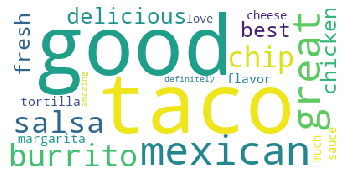

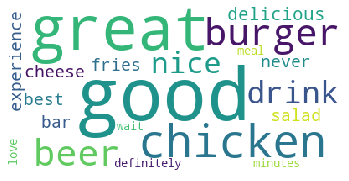

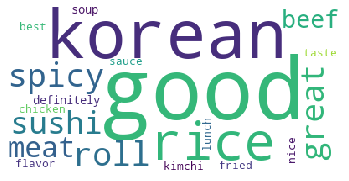

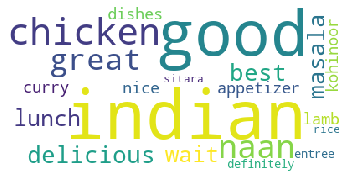

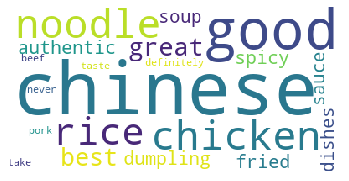

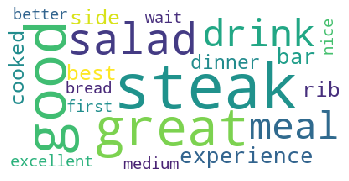

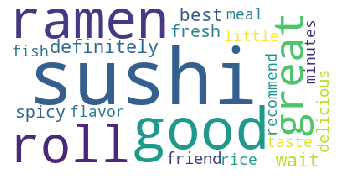

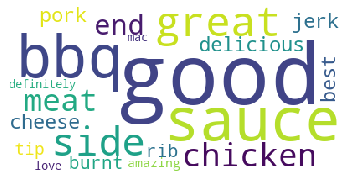

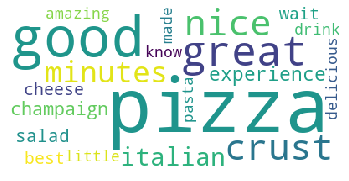

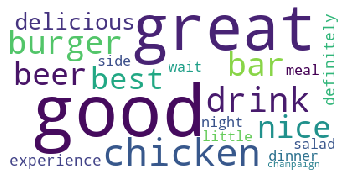

In [16]:
cuisines = ('Mexican', 'American', 'Korean', 'Indian', 'Chinese', 'Steakhouses', 'Japanese', 'Barbeque', 'Italian', 'Nightlife')

for x in cuisines:
    
    comment_words = ' '
    
    for val in df.text.where(df['categories'].str.contains(x)).dropna(): 

        val = str(val) 

        tokens = val.split() 

        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '
    
    wordcloud = WordCloud(collocations = False, background_color ='white', 
                          stopwords = stopwords, max_words = 20).generate(comment_words)
    
    plt.figure() 
    plt.imshow(wordcloud) 
    plt.axis("off")   
    plt.show()

## III. Applying LDA on Reviews

### Data Preparation
- Add stop words to omit from text analysis
- Clean up data
    - Remove new line characters
    - Remove single quotation marks
    - Remove distinction between capitalized and non-capitalized words
- Change the reviews from sentences into words
- Build bigram models in order to group together common two-word phrases
- Remove stop words and combine phrases 

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','come','order','try','go',
                   'get','make','drink','plate','dish','restaurant','place','would',
                   'really','like','great','service','came','got'])

In [8]:
## set up data as a list and remove unwanted characters

data = df.text.values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

<>:4: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-620723a8d68f>:4: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [12]:
## break up list of sentences to list of words

def all_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(all_words(data))

In [13]:
## group together phrases

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [14]:
def remove_stopwords(texts):
    '''
    takes in list of reviews 
    returns list without stopwords
    '''
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    '''
    takes in list of reviews
    returns list with two word phrases grouped as one 
    '''
    return [bigram_mod[doc] for doc in texts]

In [15]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

### LDA Model
- Create the corpus, acting as a list of vectors equal to the number of documents
- Generate the LDA model
- Ouput the resulting topics 
    - Each topic lists key words found throughout that topic and the frequency in which they occur
        - For example: Topic #2 is most likely refrencing pizza places, Topic #5 refrences korean food

In [16]:
## generate corpus

id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

#### Generate the LDA model and output the topics. 

In [26]:
## generate lda model and output topics

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 15, 
                                           random_state = 100, update_every = 1, chunksize = 100,
                                           passes = 10, alpha = 'auto', per_word_topics = True)
lda_model.print_topics()

[(0,
  '0.068*"number" + 0.060*"glad" + 0.034*"attention" + 0.027*"refills" + 0.027*"healthy" + 0.022*"mess" + 0.021*"adding" + 0.021*"problems" + 0.019*"desired" + 0.019*"rate"'),
 (1,
  '0.098*"sushi" + 0.048*"wings" + 0.047*"bread" + 0.043*"coming" + 0.036*"enjoy" + 0.024*"reasonable" + 0.023*"cool" + 0.023*"chicago" + 0.022*"platter" + 0.019*"solid"'),
 (2,
  '0.220*"pizza" + 0.054*"week" + 0.045*"often" + 0.041*"veggies" + 0.030*"crust" + 0.024*"job" + 0.022*"guys" + 0.022*"year" + 0.020*"employee" + 0.018*"sorry"'),
 (3,
  '0.098*"coffee" + 0.078*"rolls" + 0.048*"recommended" + 0.044*"slightly" + 0.039*"environment" + 0.035*"ones" + 0.031*"chain" + 0.022*"tomato" + 0.020*"par" + 0.018*"hell"'),
 (4,
  '0.118*"excellent" + 0.056*"attentive" + 0.048*"friend" + 0.046*"fantastic" + 0.041*"wife" + 0.029*"broth" + 0.027*"downtown" + 0.024*"boyfriend" + 0.023*"polite" + 0.021*"saturday"'),
 (5,
  '0.060*"done" + 0.060*"feel" + 0.054*"roll" + 0.049*"real" + 0.048*"bowl" + 0.047*"business

### Analyzing & Visualizing the Model
- Output the perplexity of the model
    - We look for as low a perplexity as possible so our score of -19 is fairly good
- The visualization below highlights different topics and their keywords
    - The larger the bubble, the more frequent the topic
    - Rolling over bubble will display most used words within that topic
- We can infer the following topics from the largest bubbles
    1. Wait times
    2. Sushi 
    3. BBQ 
    4. Chinese food

In [27]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -12.342981049515883


In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.325234 -0.194057       1        1  32.496010
13    -0.309575  0.255128       2        1  24.271706
9     -0.256875  0.191457       3        1  15.363091
10    -0.240144 -0.271805       4        1  13.418134
1      0.023339  0.016110       5        1   2.838597
8      0.061042  0.005713       6        1   2.398188
4      0.079314  0.002795       7        1   1.798673
5      0.091214  0.001752       8        1   1.646349
2      0.081748  0.002586       9        1   1.597701
11     0.089479  0.001843      10        1   1.519282
7      0.116456 -0.000255      11        1   1.122118
3      0.137936 -0.001934      12        1   0.653845
0      0.144897 -0.002494      13        1   0.447748
12     0.150729 -0.003086      14        1   0.292241
6      0.155675 -0.003753      15        1   0.136321, topic_info=      Category         Freq          Term        Total  loglift  logprob
130    Default  3608.000000          good  3608.000000  30.0000  30.0000
11     Default  4773.000000          food  4773.000000  29.0000  29.0000
287    Default   701.000000         pizza   701.000000  28.0000  28.0000
228    Default  1942.000000       chicken  1942.000000  27.0000  27.0000
356    Default  1511.000000          also  1511.000000  26.0000  26.0000
108    Default  1868.000000          time  1868.000000  25.0000  25.0000
190    Default  1970.000000           one  1970.000000  24.0000  24.0000
105    Default   557.000000         sushi   557.000000  23.0000  23.0000
625    Default  1644.000000       ordered  1644.000000  22.0000  22.0000
410    Default  1276.000000          best  1276.000000  21.0000  21.0000
797    Default   951.000000        pretty   951.000000  20.0000  20.0000
933    Default   423.000000     excellent   423.000000  19.0000  19.0000
234    Default  1191.000000     delicious  1191.000000  18.0000  18.0000
121    Default  1188.000000           ive  1188.000000  17.0000  17.0000
144    Default   875.000000        little   875.000000  16.0000  16.0000
293    Default  1125.000000        always  1125.000000  15.0000  15.0000
561    Default  1121.000000          nice  1121.000000  14.0000  14.0000
460    Default  1104.000000          well  1104.000000  13.0000  13.0000
233    Default  1058.000000    definitely  1058.000000  12.0000  12.0000
110    Default   789.000000           two   789.000000  11.0000  11.0000
304    Default   698.000000         lunch   698.000000  10.0000  10.0000
532    Default   899.000000          menu   899.000000   9.0000   9.0000
644    Default   614.000000          town   614.000000   8.0000   8.0000
133    Default   649.000000          side   649.000000   7.0000   7.0000
336    Default   647.000000        flavor   647.000000   6.0000   6.0000
242    Default   862.000000      friendly   862.000000   5.0000   5.0000
890    Default  1071.000000            us  1071.000000   4.0000   4.0000
59     Default   577.000000           bar   577.000000   3.0000   3.0000
101    Default   828.000000         staff   828.000000   2.0000   2.0000
564    Default   616.000000         salad   616.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
2924   Topic15     0.017400         shelf     1.031268   2.5159  -9.6560
10073  Topic15     0.017403        affect     1.031475   2.5158  -9.6558
3082   Topic15     0.017456        actual     1.034645   2.5158  -9.6528
12771  Topic15     0.017407      playgirl     1.031763   2.5158  -9.6556
12770  Topic15     0.017407      kamikaze     1.031812   2.5157  -9.6556
7546   Topic15     0.017407         waits     1.031912   2.5156  -9.6556
4724   Topic15     0.017407          dirt     1.031986   2.5155  -9.6556
1558   Topic15     0.017400        locked     1.031574   2.5156  -9.6560
2070   Topic15     0.017408            bc     1.032554   2.5151  -9.6555
1850   Topic15     0.017419      negative     

### Choosing Optimal Number of Topics
- Loop through different number of topics and plot the corresponding perplexities 
- Plot shows a higher number of topics yields a better perplexity
- Optimal number of topics: 15
    - Plot shows a steep drop off and then begins to level out around 15 topics

In [22]:
## calculate perplexities

min_topics = 5
max_topics = 20
perp = []
for topics in range(min_topics, max_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = topics, 
                                           random_state = 100, update_every = 1, chunksize = 100,
                                           passes = 10, alpha = 'auto', per_word_topics = True)
    perp.append(lda_model.log_perplexity(corpus))    

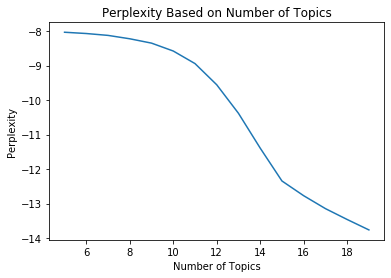

In [23]:
sea.lineplot(range(min_topics, max_topics), perp)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity Based on Number of Topics')
plt.show()

### Accessing Correlation Between Star Rating and Sentiment
- Use a sentiment analyzer to add a column to our dataframe indicating whether the review is positive or negative
- Calculate the correlation amongst the variables in the data frame and visualize in heat map
    - There is a ~0.56 correlation between star rating and sentiment
    - There is a higher correlation between positive reviews and sentiment rather than negative reviews
        - This implies that positive reviewers are more accurately rating the restaurant

In [51]:
## adds values to measure negativity, neutrality, positivity, and a value to combine all into one

sid = SentimentIntensityAnalyzer()
df['sentiments'] = df['text'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [57]:
df['sent'] = np.where(df['compound'] >= 0, 'pos', 'neg')
df['sent_val'] = np.where(df['sent'] == 'pos', 1, 0)

In [58]:
df.head()

,business_id,name,state,categories,stars,date,text,neg,neu,pos,compound,sent,sent_val
2,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-12-02 20:22:26,I would have given this restaurant zero stars ...,0.116,0.884,0.000,-0.7430,neg,0
3,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-12-16 04:31:05,So...no. Just...no. Before I picked up a plate...,0.054,0.922,0.025,-0.4019,neg,0
4,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-05-13 23:25:06,It's impressive how filthy this place is. Some...,0.117,0.793,0.090,-0.3352,neg,0
5,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-09-11 00:34:30,The worst buffet I've ever had. Not worth of t...,0.211,0.789,0.000,-0.7866,neg,0
6,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,IL,"Sushi Bars, Buffets, Restaurants, Chinese",1.0,2017-03-18 04:29:55,Good food east side of building outside is ab...,0.328,0.532,0.140,-0.5984,neg,0


In [59]:
df.corr()

,stars,neg,neu,pos,compound,sent_val
stars,1.000000,-0.551817,-0.384839,0.616375,0.651395,0.562756
neg,-0.551817,1.000000,-0.029878,-0.477766,-0.748271,-0.700612
neu,-0.384839,-0.029878,1.000000,-0.863814,-0.282478,-0.188036
pos,0.616375,-0.477766,-0.863814,1.000000,0.625426,0.518408
compound,0.651395,-0.748271,-0.282478,0.625426,1.000000,0.917180
sent_val,0.562756,-0.700612,-0.188036,0.518408,0.917180,1.000000


//anaconda3/lib/python3.7/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
//anaconda3/lib/python3.7/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


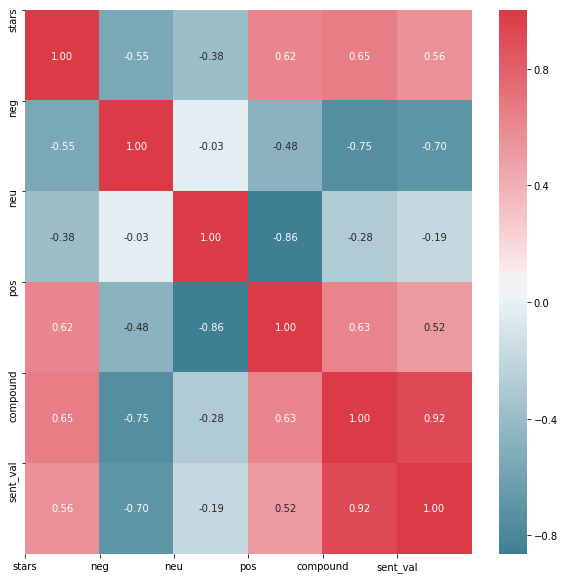

In [63]:
def heatMap(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (10, 10))
    colormap = sea.diverging_palette(220, 10, as_cmap = True)
    sea.heatmap(corr, cmap = colormap, annot = True, fmt = ".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
heatMap(df)

##### The bar chart reiterates the correlation. Almost all of the five star restaurants had positive reviews, but only about two-thirds of one star restaurants had negative reviews.

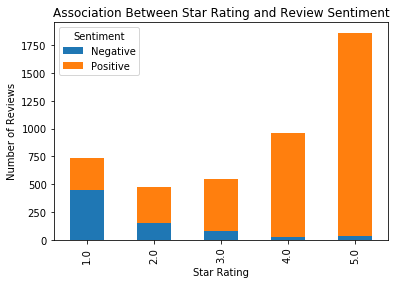

In [70]:
df.groupby(['stars', 'sent']).size().unstack().plot(kind = 'bar',stacked = True)
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Association Between Star Rating and Review Sentiment')
plt.legend(['Negative', 'Positive'], title = 'Sentiment')
plt.show()